Reference from https://blog.keras.io/building-autoencoders-in-keras.html.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Add noise to the dataset from gaussian distribution

def add_noise(data, factor=0.5):
    noisy_data = data + factor*np.random.normal(0, 1, size=data.shape)
    noisy_data = np.clip(noisy_data, 0, 1)

    return noisy_data

In [ ]:
# Plotting the first count samples from the dataset

def plot_samples(count, *datasets):
    n, r, c = len(datasets[0]), len(datasets), count
    fig, axes = plt.subplots(nrows=len(datasets), ncols=count, figsize=(2*c, 2*r))
    sample_indices = np.random.choice(range(n), count, replace=False)

    for i, dataset in enumerate(datasets):
        sample = np.squeeze(dataset[sample_indices], axis=-1)

        for j, ax in enumerate(axes[i]):
            ax.axis('off')
            ax.imshow(sample[j], cmap='gray')

    fig.subplots_adjust(wspace=0.1, hspace=0.1)

Denoising Handwritten MNIST dataset using Linear AutoEncoders

In [ ]:
# Load the MNIST dataset

(mnist_train, __) , (mnist_val, __) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
def preprocess(data):
    data = data.astype("float32")
    # Normalize the dataset
    data = data / 255
    # Convert from (H, W) to (H, W, C), C=1 for grayscale images
    data = np.expand_dims(data, 3)
    
    return data

In [ ]:
# Preprocess and add noise to the training and test datasets
mnist_train, mnist_val = preprocess(mnist_train), preprocess(mnist_val)
mnist_noise_train, mnist_noise_val = add_noise(mnist_train), add_noise(mnist_val)

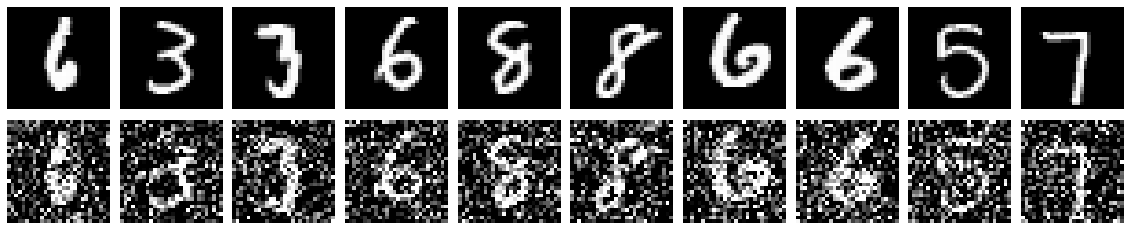

In [ ]:
# Plot 10 samples from the clean and noisy train dataset
plot_samples(10, mnist_train, mnist_noise_train)

In [ ]:
from matplotlib.image import NonUniformImage
from tensorflow import keras

class LinearAutoEncoder():
    def __init__(self, in_dims, latent_dims=8):
        super().__init__()
        self.in_dims = in_dims
        self.latent_dims = latent_dims

    def _get_encoder(self, x, latent_dims):
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(64, activation='relu')(x)
        x = keras.layers.Dense(32, activation='relu')(x)
        x = keras.layers.Dense(latent_dims, activation='relu')(x)
        
        return x
    
    def _get_decoder(self, x, out_dims):
        x = keras.layers.Dense(32, activation='relu')(x)
        x = keras.layers.Dense(64, activation='relu')(x)
        hwc = out_dims[0] * out_dims[1] * out_dims[2]
        x = keras.layers.Dense(hwc, activation='sigmoid')(x)

        return x

    def build(self):
        inp = keras.layers.Input(self.in_dims)
        enc_out = self._get_encoder(inp, self.latent_dims)
        dec_out = self._get_decoder(enc_out, self.in_dims)
        out = keras.layers.Reshape(in_dims)(dec_out)

        return tf.keras.Model(inp, out)

In [ ]:
in_dims = mnist_train.shape[1:]

mnist_ae = LinearAutoEncoder(in_dims).build()
mnist_ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 32)                288       
                                                                 
 dense_4 (Dense)             (None, 64)                2112  

In [ ]:
mnist_ae.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError()
)

In [ ]:
history = mnist_ae.fit(
    mnist_noise_train, mnist_train,
    batch_size=64, epochs=10, shuffle=True,
    validation_data=(mnist_noise_val, mnist_val),
)

Epoch 1/10
938/938 [==============================] - 6s 3ms/step - loss: 0.0554 - val_loss: 0.0400
Epoch 2/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0376 - val_loss: 0.0354
Epoch 3/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0347 - val_loss: 0.0336
Epoch 4/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0332 - val_loss: 0.0323
Epoch 5/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0321 - val_loss: 0.0319
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0313 - val_loss: 0.0310
Epoch 7/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0306 - val_loss: 0.0305
Epoch 8/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0301 - val_loss: 0.0301
Epoch 9/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0297 - val_loss: 0.0296
Epoch 10/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0294 - val_loss: 0.0297

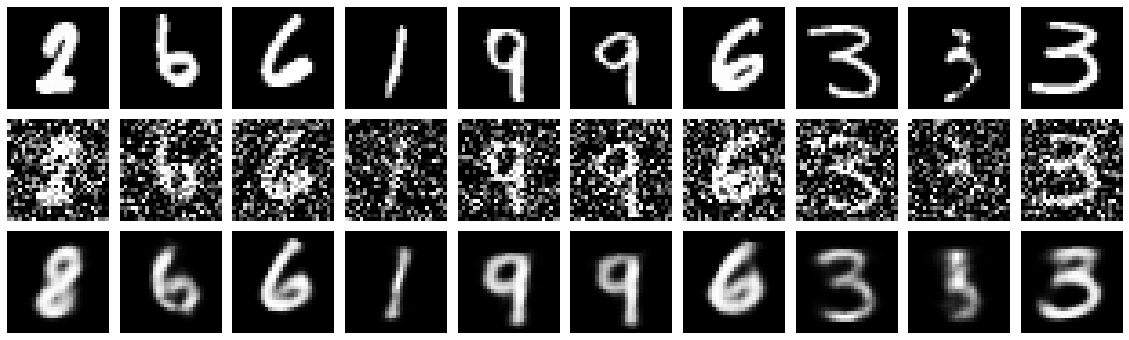

In [ ]:
#  Plot 10 samples from original, noisy and denoised dataset.
mnist_denoise_val = mnist_ae.predict(mnist_noise_val)
plot_samples(10, mnist_val, mnist_noise_val, mnist_denoise_val)

Denoising Fashion MNIST dataset using Convolutional AutoEncoders

In [ ]:
(fmnist_train, _) , (fmnist_val, _) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
# Preprocess and add noise to the training and test datasets
fmnist_train, fmnist_val = preprocess(fmnist_train), preprocess(fmnist_val)
fmnist_noise_train, fmnist_noise_val = add_noise(fmnist_train), add_noise(fmnist_val)

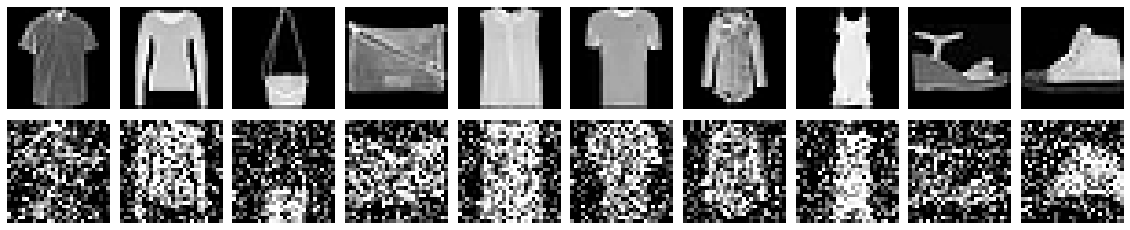

In [ ]:
# Plot 10 samples from the clean and noisy train dataset
plot_samples(10, fmnist_train, fmnist_noise_train)

In [ ]:
in_dims = fmnist_train.shape[1:]

fmnist_lae = LinearAutoEncoder(in_dims).build()

fmnist_lae.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError()
)

In [ ]:
history = fmnist_lae.fit(
    fmnist_noise_train, fmnist_train, batch_size=64, epochs=10, shuffle=True,
    validation_data=(fmnist_noise_val, fmnist_val),
)

Epoch 1/10
938/938 [==============================] - 4s 3ms/step - loss: 0.0445 - val_loss: 0.0304
Epoch 2/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0279 - val_loss: 0.0265
Epoch 3/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0257 - val_loss: 0.0252
Epoch 4/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0245 - val_loss: 0.0242
Epoch 5/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0237 - val_loss: 0.0235
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0231 - val_loss: 0.0231
Epoch 7/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0227 - val_loss: 0.0229
Epoch 8/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0224 - val_loss: 0.0227
Epoch 9/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0221 - val_loss: 0.0224
Epoch 10/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0219 - val_loss: 0.0221

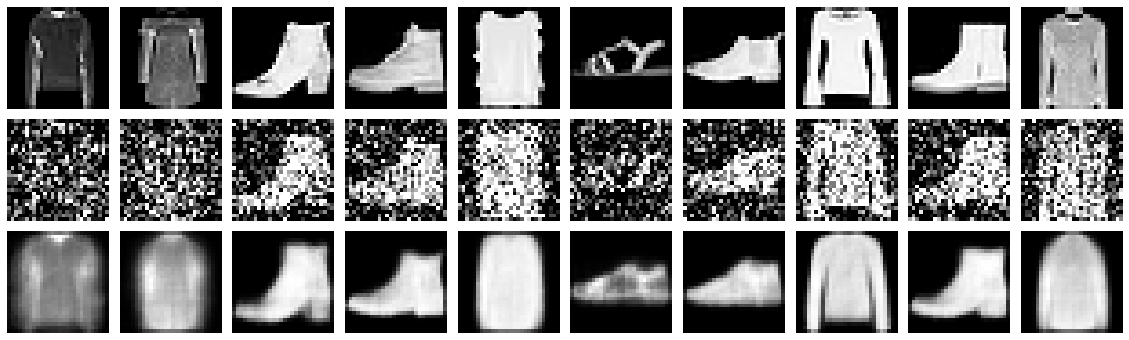

In [ ]:
# Predict on the `fmnist_noise_val` dataset and plot 10 samples
fmnist_l_denoise_val = fmnist_lae.predict(fmnist_noise_val)
plot_samples(10, fmnist_val, fmnist_noise_val, fmnist_l_denoise_val)

In [ ]:
class ConvAutoEncoder:
    def __init__(self, in_dims, latent_dims=8):
        self.in_dims = in_dims
        self.latent_dims = latent_dims

    def _get_encoder(self, x, latent_dims):
        x = keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same')(x)
        x = keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
        x = keras.layers.Conv2D(48, kernel_size=(3, 3), padding='same')(x)
        x = keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
        x = keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same')(x)
        x = keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)

        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(128, activation='relu')(x)
        x = keras.layers.Dense(96, activation='relu')(x)
        x = keras.layers.Dense(96, activation='relu')(x)
        x = keras.layers.Dense(64, activation='relu')(x)
        x = keras.layers.Dense(latent_dims, activation='relu')(x)

        return x
    
    def _get_decoder(self, x, out_dims):
        x = keras.layers.Dense(64, activation='relu')(x)
        x = keras.layers.Dense(96, activation='relu')(x)
        x = keras.layers.Dense(96, activation='relu')(x)
        x = keras.layers.Dense(128, activation='relu')(x)
        hwc = out_dims[0] * out_dims[1] * out_dims[2]
        x = keras.layers.Dense(hwc, activation='sigmoid')(x)
        x = keras.layers.Reshape(out_dims)(x)

        x = keras.layers.Conv2DTranspose(48, kernel_size=(3, 3), padding='same')(x)
        x = keras.layers.Conv2DTranspose(48, kernel_size=(3, 3), padding='same')(x)
        x = keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), padding='same')(x)

        return x

    def build(self):

        dense_out = (self.in_dims[0], self.in_dims[1], 48)

        inp = keras.layers.Input(self.in_dims)
        enc_out = self._get_encoder(inp, self.latent_dims)
        dec_out = self._get_decoder(enc_out, dense_out)
        out = keras.layers.Conv2D(1, kernel_size=(1, 1), padding='same')(dec_out)

        return tf.keras.Model(inp, out)

In [ ]:
fmnist_cae = ConvAutoEncoder(in_dims, latent_dims=48).build()
fmnist_cae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 48)        27696     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 48)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        2771

In [ ]:
fmnist_cae.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError()
)

In [ ]:
history = fmnist_cae.fit(
    fmnist_noise_train, fmnist_train, batch_size=64, epochs=10, shuffle=True,
    validation_data=(fmnist_noise_val, fmnist_val),
)

Epoch 1/10
938/938 [==============================] - 28s 21ms/step - loss: 0.0508 - val_loss: 0.0244
Epoch 2/10
938/938 [==============================] - 19s 21ms/step - loss: 0.0219 - val_loss: 0.0210
Epoch 3/10
938/938 [==============================] - 20s 21ms/step - loss: 0.0203 - val_loss: 0.0200
Epoch 4/10
938/938 [==============================] - 20s 21ms/step - loss: 0.0192 - val_loss: 0.0187
Epoch 5/10
938/938 [==============================] - 20s 21ms/step - loss: 0.0182 - val_loss: 0.0184
Epoch 6/10
938/938 [==============================] - 20s 21ms/step - loss: 0.0175 - val_loss: 0.0180
Epoch 7/10
938/938 [==============================] - 20s 21ms/step - loss: 0.0169 - val_loss: 0.0173
Epoch 8/10
938/938 [==============================] - 20s 21ms/step - loss: 0.0164 - val_loss: 0.0173
Epoch 9/10
938/938 [==============================] - 20s 21ms/step - loss: 0.0160 - val_loss: 0.0170
Epoch 10/10
938/938 [==============================] - 20s 21ms/step - loss: 0.015

In [ ]:
# Predict on the `fmnist_noise_val` dataset and plot 10 samples
fmnist_c_denoise_val = fmnist_cae.predict(fmnist_noise_val)

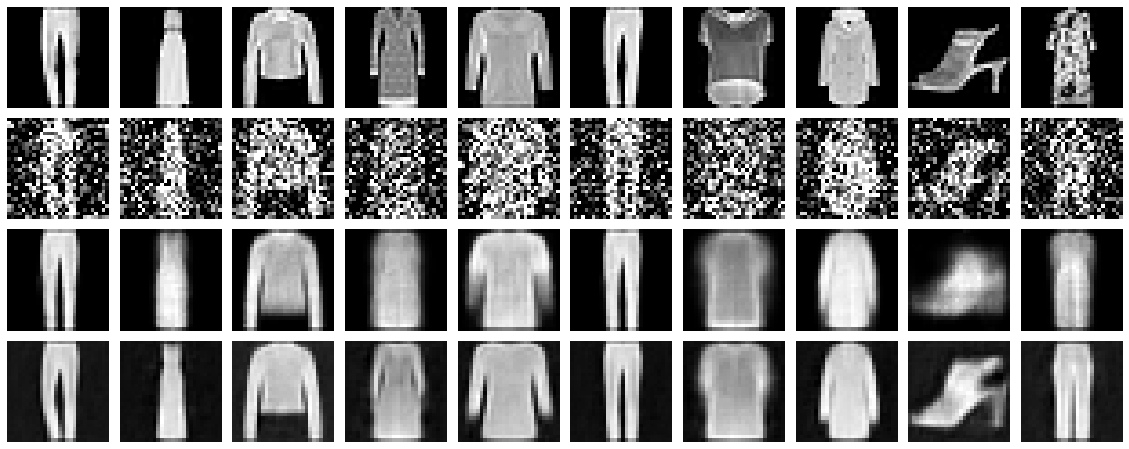

In [ ]:
# Plot original, noised, denoised linear and denoised conv output.
plot_samples(10, fmnist_val, fmnist_noise_val, fmnist_l_denoise_val, fmnist_c_denoise_val)